# Binary Classification

## Creating data

### Creating a toy dataset

In [418]:
from sklearn.datasets import make_circles

# Make 1000 circles
n_samples = 1000

# Create the circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [419]:
# Visualize the data

print(f"First 10 samples of X: {X[:10]}")
print(f"First 10 samples of y: {y[:10]}")

First 10 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First 10 samples of y: [1 1 1 1 0 1 1 1 1 0]


In [420]:
# Creating a Pandas dataframe

import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


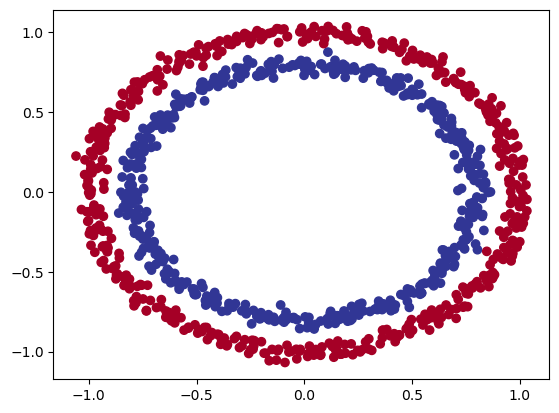

In [421]:
# Visualize data (but better)

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

### Fitting data to pytorch (conversion)

In [422]:
import torch

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

### Split data (using sklearn)

In [423]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building the model

In [424]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [425]:
# Build the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2, out_features=5)
        self.linear_layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.linear_layer2(self.linear_layer1(X))

# Create an instance of the model
model0 = CircleModel().to(device)
model0

CircleModel(
  (linear_layer1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [426]:
# Check model's device
next(model0.parameters()).device

device(type='cuda', index=0)

In [427]:
# Build the model (another way)

model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model0, model0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[-0.0829, -0.2872],
                       [ 0.4691, -0.5582],
                       [-0.3260, -0.1997],
                       [-0.4252,  0.0667],
                       [-0.6984,  0.6386]], device='cuda:0')),
              ('0.bias',
               tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
              ('1.weight',
               tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
              ('1.bias', tensor([-0.1213], device='cuda:0'))]))

In [428]:
# Predictions with untrained model

with torch.inference_mode():
    y_pred = model0(X_test.to(device))

print(f"Test data shape: {X_test.shape}  {y_test.shape} ")
print(f"Predictions shape: {y_pred.shape}")
print(f"First 10 test labels: {y_test[:10]}")
print(f"First 10 predictions: {y_pred[:10]}")

Test data shape: torch.Size([200, 2])  torch.Size([200]) 
Predictions shape: torch.Size([200, 1])
First 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
First 10 predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')


## Training the model

In [429]:
# Loss function and optimizer
# For classification, loss function should be Cross Entropy and optimizer should be either SGD or Adam

loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy + Sigmoid
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.01)

In [430]:
# Defining an accuracy function

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

In [431]:
# Before defining the training loop
# The model outputs what is known as logits. Logits can be converted to probabilities using activation functions (e.g. sigmoid or softmax)
# In math (or with sigmoid), a logit of 0 is equivalent to a probability of 0.5. Logit<0 then Prob<0.5 and Logit>0 then Prob>0.5.

with torch.inference_mode():
    y_logits = model0(X_test.to(device))
y_pred_probs = torch.sigmoid(y_logits)
y_pred = torch.round(y_pred_probs)  # If y>=0.5 -> y=1; Else y=0

print(f"Before activation (logits): {y_logits[:5]}")
print(f"After activation (probabilites): {y_pred_probs[:5]}")
print(f"Output (labels): {y_pred[:5]}")

Before activation (logits): tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')
After activation (probabilites): tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')
Output (labels): tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')


In [432]:
# Defining the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train_model(epochs):
    for epoch in range(1, epochs+1):
        model0.train()

        # Clear gradients
        model0.zero_grad()

        # Forward pass
        y_logits = model0(X_train).squeeze()  # Model outputs logits
        y_pred = torch.round(torch.sigmoid(y_logits))  # Convert to probs

        # Calculate loss (and accuracy)
        loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss
        acc = accuracy_fn(y_train, y_pred)

        # Backpropagation
        loss.backward()

        # Optimization step
        optimizer.step()

        model0.eval()

        with torch.inference_mode():
            # Forward pass
            test_logits = model0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss
        test_acc = accuracy_fn(y_test, test_pred)
        test_loss = loss_fn(test_logits, y_test)

        # Print data
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss} | Accuracy: {acc} | Test accuracy: {test_acc}")

In [433]:
# Train model

train_model(100)

Epoch: 10 | Loss: 0.6934800744056702 | Test loss: 0.6933944821357727 | Accuracy: 0.5 | Test accuracy: 0.5
Epoch: 20 | Loss: 0.6931270956993103 | Test loss: 0.6959896683692932 | Accuracy: 0.52 | Test accuracy: 0.47
Epoch: 30 | Loss: 0.6930614113807678 | Test loss: 0.6953103542327881 | Accuracy: 0.5 | Test accuracy: 0.47
Epoch: 40 | Loss: 0.692998468875885 | Test loss: 0.6944469213485718 | Accuracy: 0.515 | Test accuracy: 0.47
Epoch: 50 | Loss: 0.6929891705513 | Test loss: 0.6943706274032593 | Accuracy: 0.5075 | Test accuracy: 0.455
Epoch: 60 | Loss: 0.6929814219474792 | Test loss: 0.6947596073150635 | Accuracy: 0.51875 | Test accuracy: 0.455
Epoch: 70 | Loss: 0.692981481552124 | Test loss: 0.6947774291038513 | Accuracy: 0.5125 | Test accuracy: 0.46
Epoch: 80 | Loss: 0.692980170249939 | Test loss: 0.6946606040000916 | Accuracy: 0.515 | Test accuracy: 0.455
Epoch: 90 | Loss: 0.6929800510406494 | Test loss: 0.6946418881416321 | Accuracy: 0.515 | Test accuracy: 0.445
Epoch: 100 | Loss: 0.69

## Predictions with the model

In [434]:
# Getting some helper functions from course material

import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    print("Download complete")

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


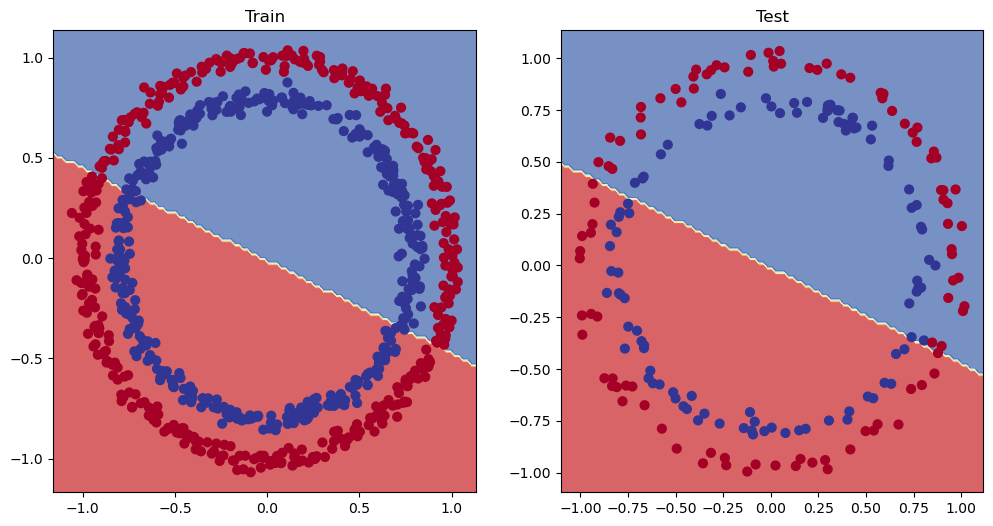

In [435]:
# Plot decision boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

## Improving the model

### Building new model

In [436]:
# Define new model to improve previous one
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class CircleModelImproved(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2, out_features=16)
        self.linear_layer2 = nn.Linear(in_features=16, out_features=16)
        self.linear_layer3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear_layer3(self.relu(self.linear_layer2(self.relu(self.linear_layer1(x)))))
    
# Create model instance
model1 = CircleModelImproved()
model1, model1.state_dict()

(CircleModelImproved(
   (linear_layer1): Linear(in_features=2, out_features=16, bias=True)
   (linear_layer2): Linear(in_features=16, out_features=16, bias=True)
   (linear_layer3): Linear(in_features=16, out_features=1, bias=True)
   (relu): ReLU()
 ),
 OrderedDict([('linear_layer1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802],
                       [-0.3258, -0.0829],
                       [-0.2872,  0.4691],
                       [-0.5582, -0.3260],
                       [-0.1997, -0.4252],
                       [ 0.0667, -0.6984],
                       [ 0.6386, -0.6007]])),
              (

In [437]:
# Migrate improved model to cuda

model1.to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### Training new model

In [438]:
# Loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                             lr=0.01)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [439]:
# Building the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train_model(epochs):
    for epoch in range(1, epochs+1):
        model1.train()

        model1.zero_grad()
        y_logits = model1(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
        loss = loss_fn(y_logits, y_train)
        loss.backward()
        optimizer.step()

        model1.eval()

        with torch.inference_mode():
            test_logits = model1(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if (epoch % 50 == 0):
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss} | Accuracy: {acc} | Test accuracy: {test_acc}")

In [440]:
train_model(400)

Epoch: 50 | Loss: 0.3493654429912567 | Test loss: 0.37115851044654846 | Accuracy: 0.9975 | Test accuracy: 0.995
Epoch: 100 | Loss: 0.015947487205266953 | Test loss: 0.0329822301864624 | Accuracy: 1.0 | Test accuracy: 1.0


Epoch: 150 | Loss: 0.0055950842797756195 | Test loss: 0.01633571833372116 | Accuracy: 1.0 | Test accuracy: 1.0
Epoch: 200 | Loss: 0.0032170936465263367 | Test loss: 0.011519476771354675 | Accuracy: 1.0 | Test accuracy: 1.0
Epoch: 250 | Loss: 0.002105862135067582 | Test loss: 0.008894558064639568 | Accuracy: 1.0 | Test accuracy: 1.0
Epoch: 300 | Loss: 0.0015150569379329681 | Test loss: 0.007487419061362743 | Accuracy: 1.0 | Test accuracy: 1.0
Epoch: 350 | Loss: 0.001135292463004589 | Test loss: 0.006358957849442959 | Accuracy: 1.0 | Test accuracy: 1.0
Epoch: 400 | Loss: 0.0008931781048886478 | Test loss: 0.0054926457814872265 | Accuracy: 1.0 | Test accuracy: 1.0


### Predictions with the model

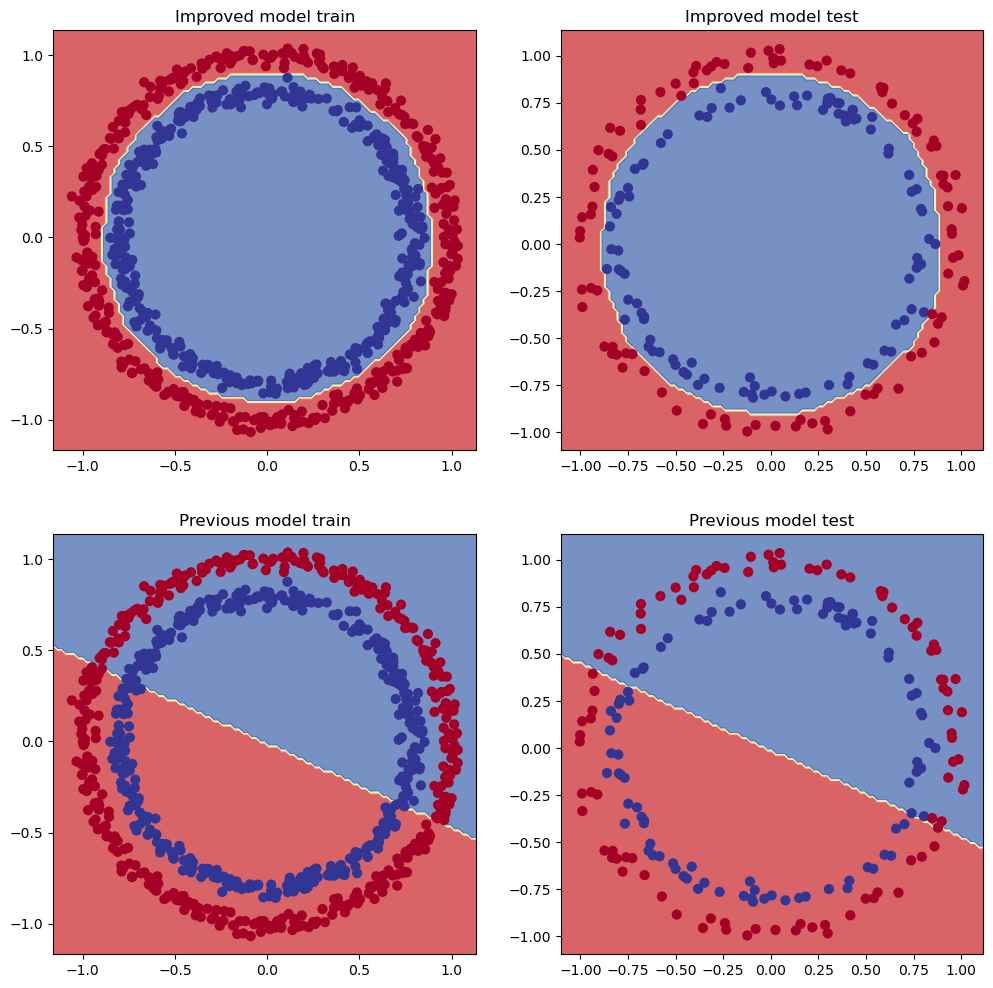

In [441]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plot_decision_boundary(model1, X_train, y_train)
plt.title("Improved model train")
plt.subplot(2, 2, 2)
plot_decision_boundary(model1, X_test, y_test)
plt.title("Improved model test")
plt.subplot(2, 2, 3)
plot_decision_boundary(model0, X_train, y_train)
plt.title("Previous model train")
plt.subplot(2, 2, 4)
plot_decision_boundary(model0, X_test, y_test)
plt.title("Previous model test");

# Multi-class Classification

## Preparing data

In [442]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [443]:
# Setting hyperparameters for data creation

NUM_SAMPLES = 1000
NUM_FEATURES = 2
NUM_CLASSES = 5
RANDOM_SEED = 42

X, y = make_blobs(n_samples=NUM_SAMPLES,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.4,
                  random_state=RANDOM_SEED)

X[:5], y[:5]

(array([[  5.17215583,   2.82798973],
        [  2.66936246,   0.88422632],
        [ -5.799249  , -10.86806926],
        [  5.42358546,   3.4862627 ],
        [  1.124226  ,   4.76614312]]),
 array([1, 1, 2, 1, 4]))

In [444]:
# Converting data to tensors

X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.int64)

X[:5], y[:5]

(tensor([[  5.1722,   2.8280],
         [  2.6694,   0.8842],
         [ -5.7992, -10.8681],
         [  5.4236,   3.4863],
         [  1.1242,   4.7661]]),
 tensor([1, 1, 2, 1, 4]))

In [445]:
# Splitting data to train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

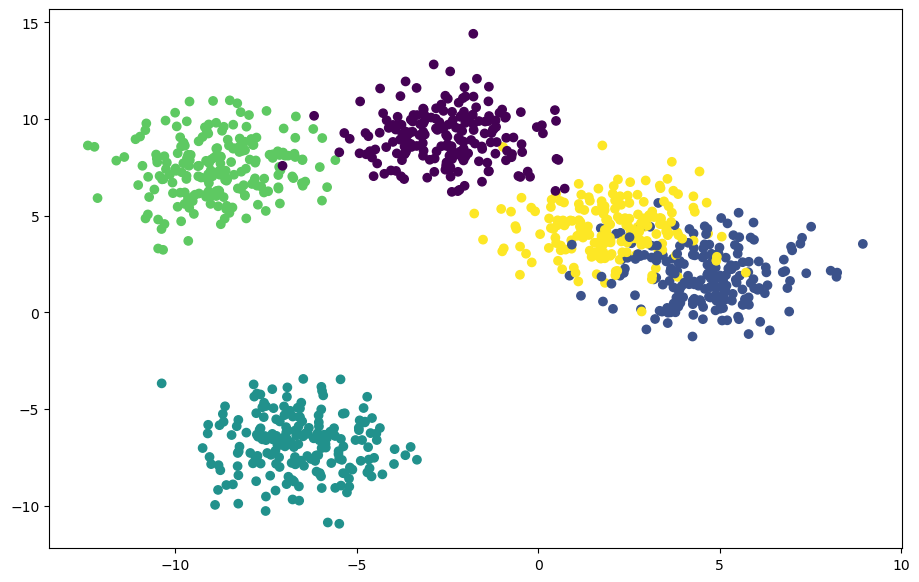

In [446]:
# Visualize the data

plt.figure(figsize=(11, 7))
plt.scatter(X[:, 0], X[:, 1], c=y);

In [447]:
# Defining the accuracy function

def accuracy_fn(y_true, y_pred):
    acc = torch.eq(y_true, y_pred).sum().item() / len(y_true)
    return acc

## Building a model

In [462]:
import torch.nn as nn
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

class BlobModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=5)
        )

    def forward(self, x):
        return self.layer_stack(x)
    
# Get an instance of the model

model2 = BlobModel()
model2, model2.state_dict()

(BlobModel(
   (layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=16, bias=True)
     (1): ReLU()
     (2): Linear(in_features=16, out_features=16, bias=True)
     (3): ReLU()
     (4): Linear(in_features=16, out_features=5, bias=True)
   )
 ),
 OrderedDict([('layer_stack.0.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802],
                       [-0.3258, -0.0829],
                       [-0.2872,  0.4691],
                       [-0.5582, -0.3260],
                       [-0.1997, -0.4252],
                       [ 0.0667, -0.6984],
                       [ 0.6386, -0.6007]])),
    

In [463]:
# Migrate the model to cuda

device = "cuda" if torch.cuda.is_available() else "cpu"
model2.to(device)
next(model2.parameters()).device

device(type='cuda', index=0)

## Training the model

In [464]:
# Loss function: Cross Entropy (accepts logits from input)
# Optimizer: Adam (same as before)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(),
                             lr=0.01)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [465]:
# Building the training loop

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train_model(epochs):
    for epoch in range(1, epochs+1):
        model2.train()

        model2.zero_grad()
        y_logits = model2(X_train).squeeze()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        acc = accuracy_fn(y_train, y_pred)
        loss = loss_fn(y_logits, y_train)
        loss.backward()
        optimizer.step()

        model2.eval()

        with torch.inference_mode():
            train_logits = model2(X_test).squeeze()
            train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(train_logits, y_test)
        test_acc = accuracy_fn(y_test, train_pred)

        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss} | Accuracy: {acc} | Test accuracy: {test_acc}")

In [466]:
# Training the model

train_model(150)

Epoch: 10 | Loss: 0.8189166784286499 | Test loss: 0.7552032470703125 | Accuracy: 0.8425 | Test accuracy: 0.815
Epoch: 20 | Loss: 0.3648484945297241 | Test loss: 0.32993224263191223 | Accuracy: 0.93875 | Test accuracy: 0.94
Epoch: 30 | Loss: 0.1941513866186142 | Test loss: 0.1898920089006424 | Accuracy: 0.94125 | Test accuracy: 0.93
Epoch: 40 | Loss: 0.16073501110076904 | Test loss: 0.16376878321170807 | Accuracy: 0.945 | Test accuracy: 0.93
Epoch: 50 | Loss: 0.1518426239490509 | Test loss: 0.15286889672279358 | Accuracy: 0.945 | Test accuracy: 0.93


Epoch: 60 | Loss: 0.1465035080909729 | Test loss: 0.14677433669567108 | Accuracy: 0.94625 | Test accuracy: 0.93
Epoch: 70 | Loss: 0.14210420846939087 | Test loss: 0.14361810684204102 | Accuracy: 0.95 | Test accuracy: 0.93
Epoch: 80 | Loss: 0.13862238824367523 | Test loss: 0.14211149513721466 | Accuracy: 0.95375 | Test accuracy: 0.93
Epoch: 90 | Loss: 0.1352878212928772 | Test loss: 0.13995598256587982 | Accuracy: 0.955 | Test accuracy: 0.93
Epoch: 100 | Loss: 0.13246910274028778 | Test loss: 0.1379815936088562 | Accuracy: 0.95625 | Test accuracy: 0.93
Epoch: 110 | Loss: 0.13027973473072052 | Test loss: 0.13669592142105103 | Accuracy: 0.9575 | Test accuracy: 0.93
Epoch: 120 | Loss: 0.12873776257038116 | Test loss: 0.13541127741336823 | Accuracy: 0.9575 | Test accuracy: 0.93
Epoch: 130 | Loss: 0.12747164070606232 | Test loss: 0.13410937786102295 | Accuracy: 0.9575 | Test accuracy: 0.93
Epoch: 140 | Loss: 0.12661899626255035 | Test loss: 0.13365668058395386 | Accuracy: 0.9575 | Test accur

## Evaluating model

In [467]:
# Predicting with the model

model2.eval()
model2.to(device)

with torch.inference_mode():
    y_logits = model2(X_test).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_pred[:10], y_test[:10]

(tensor([0, 1, 4, 2, 0, 3, 4, 1, 2, 1], device='cuda:0'),
 tensor([0, 1, 1, 2, 0, 3, 4, 1, 2, 1], device='cuda:0'))

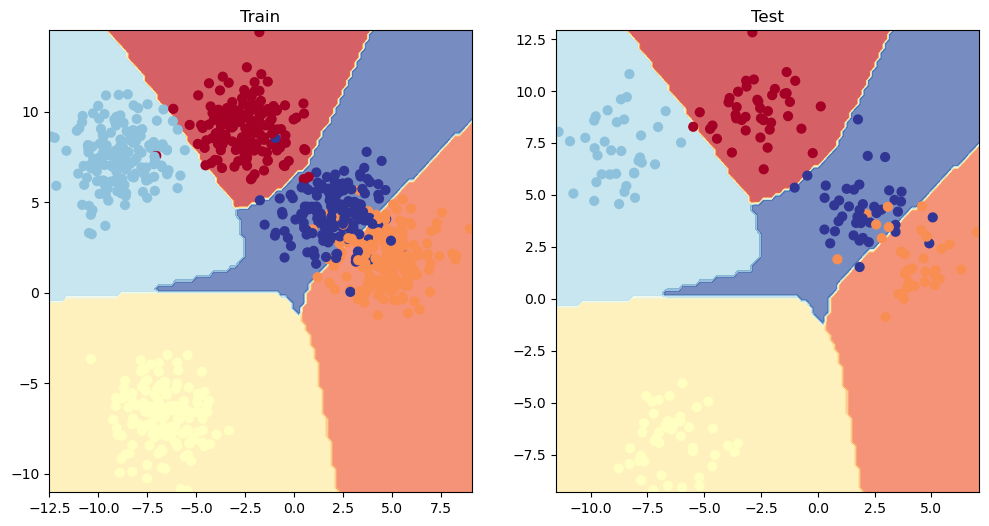

In [468]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model2, X_train, y_train)
plt.title("Train")
plt.subplot(1, 2, 2)
plot_decision_boundary(model2, X_test, y_test)
plt.title("Test");

# Saving the models

In [469]:
from pathlib import Path

PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)
MODEL0_NAME = "02-CircleModelV1.pth"
MODEL1_NAME = "02-CircleModelV2.pth"
MODEL2_NAME = "02-BlobModel.pth"
SAVING_MODEL0_PATH = PATH / MODEL0_NAME
SAVING_MODEL1_PATH = PATH / MODEL1_NAME
SAVING_MODEL2_PATH = PATH / MODEL2_NAME

In [470]:
torch.save(model0.state_dict(), SAVING_MODEL0_PATH)
torch.save(model1.state_dict(), SAVING_MODEL1_PATH)
torch.save(model2.state_dict(), SAVING_MODEL2_PATH)